In [1]:
data_location =  "../input/flickr8k"
!ls $data_location

captions.txt  Images


In [2]:
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(10)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


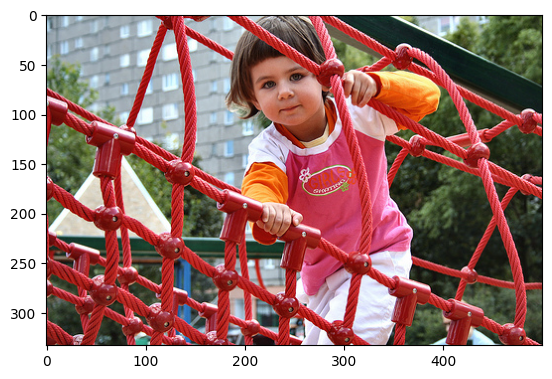

Cpation 0: A child playing on a rope net .
Cpation 1: A little girl climbing on red roping .
Cpation 2: A little girl in pink climbs a rope bridge at the park .
Cpation 3: A small child grips onto the red ropes at the playground .


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_index = 25
image_path = f"../input/flickr8k/Images/{df.iloc[data_index,0]}"
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(4):
    print(f'Cpation {i}: {df.iloc[data_index+i,1]}')

In [4]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [5]:
spacy_eng = spacy.load("en_core_web_sm")
text = "this is a, test to blah; blah 'yeahh'"
[token.text for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', ',', 'test', 'to', 'blah', ';', 'blah', "'", 'yeahh', "'"]

In [6]:
def build_vocab(text_list):
    itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
    stoi = {v:k for k,v in itos.items()}

    for text in text_list:
        for token in spacy_eng.tokenizer(text):
            token = token.text.lower()
            if token not in stoi:
                idx = len(stoi)
                stoi[token] = idx
                itos[idx] = token
    return itos, stoi

In [7]:
itos, stoi = build_vocab(["mary had a little lamb", 'itsy bitsy spider had'])
print(stoi)
print(itos)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'mary': 4, 'had': 5, 'a': 6, 'little': 7, 'lamb': 8, 'itsy': 9, 'bitsy': 10, 'spider': 11}
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'mary', 5: 'had', 6: 'a', 7: 'little', 8: 'lamb', 9: 'itsy', 10: 'bitsy', 11: 'spider'}


In [8]:
class FlickrDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.itos, self.stoi = build_vocab(df["caption"].tolist())
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"../input/flickr8k/Images/{row[0]}"
        caption = row['caption']
        img = Image.open(image_path).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.stoi["<SOS>"]]
        caption_vec += [self.stoi[token.text.lower()] for token in spacy_eng.tokenizer(caption)]
        caption_vec += [self.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec), caption
        

In [9]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

/tmp/ipykernel_36/3143496448.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = f"../input/flickr8k/Images/{row[0]}"


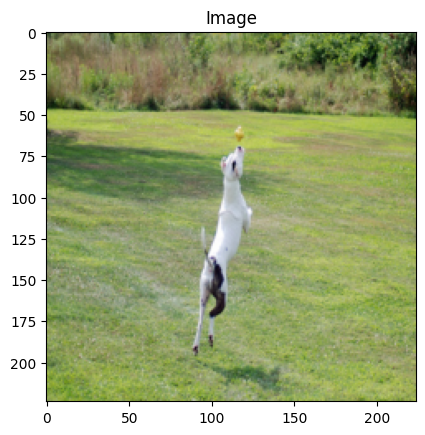

Token: tensor([  1,   4,  30,  32,  45,  31, 236,  11, 237,   4, 228, 230,  18,   2])
Sentence:
['<SOS>', 'a', 'black', 'and', 'white', 'dog', 'jumps', 'up', 'towards', 'a', 'yellow', 'toy', '.', '<EOS>']


In [10]:
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
dataset =  FlickrDataset(
    df,
    transform=transforms
)

img, caps, text = dataset[76]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.itos[token] for token in caps.tolist()])

/tmp/ipykernel_36/3143496448.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = f"../input/flickr8k/Images/{row[0]}"


torch.Size([3, 224, 224])


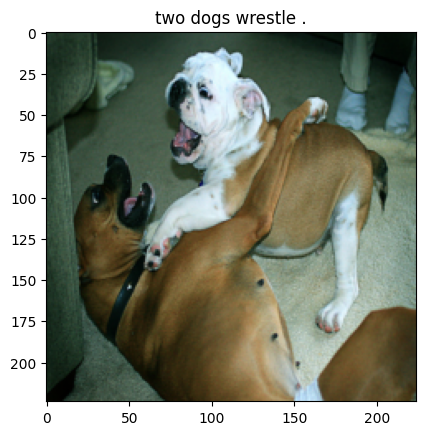

torch.Size([3, 224, 224])


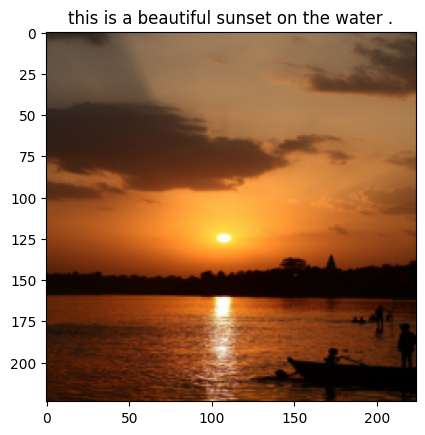

torch.Size([3, 224, 224])


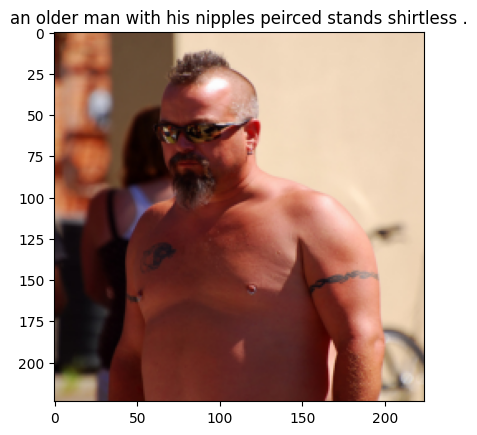

torch.Size([3, 224, 224])


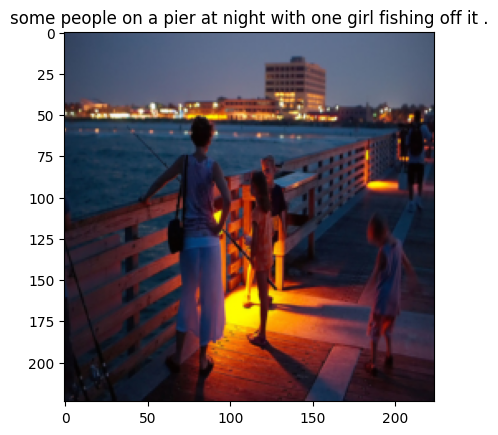

In [11]:
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    print(img.shape)
    caption_label = [dataset.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()


In [12]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [13]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.stoi)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        # images = batch, channel, resolution(224x224)
        features = self.resnet(images) # batch, 2048, 7, 7
        features = features.permute(0, 2, 3, 1) # B,7,7,2048
        b, h, w, channel = features.shape
        features = features.view(b, -1, channel)
        return features
        

In [15]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.attention_dim, self.encoder_dim, self.decoder_dim = attention_dim, encoder_dim, decoder_dim
        self.wa_encoder = nn.Linear(encoder_dim, attention_dim)
        self.wa_hiddenstate = nn.Linear(decoder_dim, attention_dim)
        self.attention = nn.Linear(attention_dim, 1)

    def forward(self, encoder_output, curr_hidden_state):
        encoded_data = self.wa_encoder(encoder_output) # B, patches, attention_dim
        curr_hidden_state_data = self.wa_hiddenstate(curr_hidden_state)
        combined_states = torch.tanh(encoded_data + curr_hidden_state_data.unsqueeze(1))
        attention_scores = self.attention(combined_states) # B, patches, 1
        attention_scores = attention_scores.squeeze(2)
        alpha = F.softmax(attention_scores,dim=1) 
        attention_weights = encoder_output * alpha.unsqueeze(2)

        #context -> weigthed sum of individual patches embedding
        context = attention_weights.sum(dim=1) # B, encoder_dim

        return alpha, context

In [16]:
class Decoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = BahdanauAttention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(dataset.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if dataset.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        return [dataset.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [17]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_size=embed_size,
            vocab_size = len(dataset.stoi),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [23]:
model_checkpoint_path = "/kaggle/input/harish-model-checkpoint-path/attention_model_state.pth"

if os.path.exists(model_checkpoint_path):
    checkpoint = torch.load(model_checkpoint_path)

model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.stoi),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

if checkpoint != None:
    print(f'Checkpoint exists !!! loading model')
    model.load_state_dict(checkpoint['state_dict'])

criterion = nn.CrossEntropyLoss(ignore_index=dataset.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Checkpoint exists !!! loading model


In [24]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.stoi),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [ ]:
num_epochs = 25
print_every = 2500
print_image_every = 5000

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            if (idx+1)%print_image_every == 0:
                model.eval()
                with torch.no_grad():
                    dataiter = iter(data_loader)
                    img,_ = next(dataiter)
                    features = model.encoder(img[0:1].to(device))
                    caps,alphas = model.decoder.generate_caption(features)
                    caption = ' '.join(caps)
                    show_image(img[0],title=caption)
                    
                model.train()
        
    #save the latest model
    save_model(model,epoch)

/tmp/ipykernel_36/3143496448.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = f"../input/flickr8k/Images/{row[0]}"


In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)